<a href="https://colab.research.google.com/github/dpflr1229/dpflr1229/blob/main/%ED%8F%AC%ED%8A%B8%ED%99%80__%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1
w = !apt install tree
print(w[-2])

Use 'apt autoremove' to remove it.


In [2]:
# 라이브러리 임포트

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display


In [3]:
# 파이토치 라이브러리
import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets

In [4]:
# warning 표시 끄기
import warnings
warnings.simplefilter('ignore')

In [5]:
# GPU 할당
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
# 공통함수 다운로드 (책참고)
!git clone https://github.com/wikibook/pythonlibs.git

# 공통 함수 불러오기
from pythonlibs.torch_lib1 import *

# 공통 함수 확인
print(README)

fatal: destination path 'pythonlibs' already exists and is not an empty directory.
Common Library for PyTorch
Author: M. Akaishi


---

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# tramsform 정의

train_transform = transforms.Compose(
    [transforms.RandomResizedCrop(224),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(0.5,0.5),
     transforms.RandomErasing(p=0.5, scale = (0.02,0.33), ratio=(0.3,0.33),value=0, inplace=False)
     ])

test_transform = transforms.Compose(
    [transforms.Resize(256),
     transforms.CenterCrop(224),
     transforms.ToTensor(),
     transforms.Normalize(0.5,0.5)]
)

In [9]:
# 이미지 불러오기
data_dir = '/content/drive/MyDrive/archive'

import os
train_dir = os.path.join(data_dir,'train')
test_dir = os.path.join(data_dir,'test') 

print(train_dir, test_dir)

# 분류 클래스 리스트
classes = ['normal', 'pothole']

/content/drive/MyDrive/archive/train /content/drive/MyDrive/archive/test


In [10]:
# 데이터셋 정의
train_data = datasets.ImageFolder(train_dir, transform = train_transform)   # 가공 O
train_data2 = datasets.ImageFolder(train_dir, transform = test_transform)   # 가공 X
test_data = datasets.ImageFolder(test_dir, transform = test_transform)

In [11]:
print(f'훈련데이터 : {len(train_data)}건')
print(f'검증데이터 : {len(test_data)}건')

훈련데이터 : 426건
검증데이터 : 255건


In [12]:
# 데이터로더 정의
batch_size = 15 # 이번에는 데이터수가 많지않기 때문

#훈련
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)

#검증
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = False)

#이미지 출력용
train_loader2 = DataLoader(train_data2, batch_size = batch_size, shuffle = False)
test_loader2 = DataLoader(test_data, batch_size = batch_size, shuffle = True)

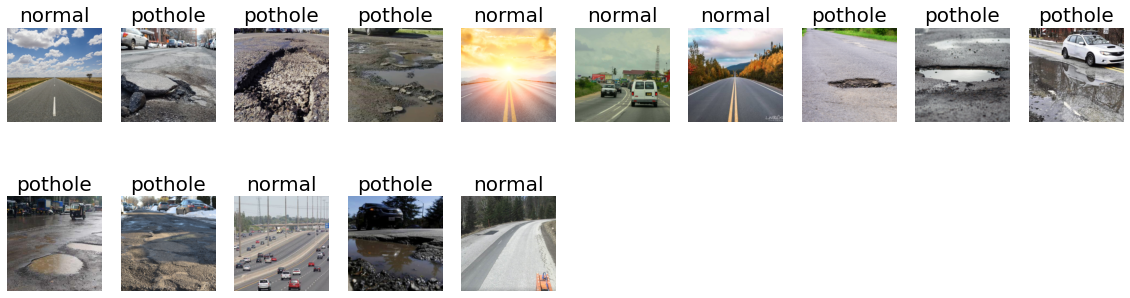

In [13]:
# 검증데이터 이미지 출력
show_images_labels(test_loader2, classes, None, None) # 교체함수 깃클론 이용

In [14]:
# 파인 튜닝

# 사전학습 모델 불러오기
from torchvision import models
net = models.resnet152(pretrained=True, progress=True)

In [15]:
# GPU 할당
net = net.to(device)
summary(net, (100,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [100, 1000]               --
├─Conv2d: 1-1                            [100, 64, 112, 112]       9,408
├─BatchNorm2d: 1-2                       [100, 64, 112, 112]       128
├─ReLU: 1-3                              [100, 64, 112, 112]       --
├─MaxPool2d: 1-4                         [100, 64, 56, 56]         --
├─Sequential: 1-5                        [100, 256, 56, 56]        --
│    └─Bottleneck: 2-1                   [100, 256, 56, 56]        --
│    │    └─Conv2d: 3-1                  [100, 64, 56, 56]         4,096
│    │    └─BatchNorm2d: 3-2             [100, 64, 56, 56]         128
│    │    └─ReLU: 3-3                    [100, 64, 56, 56]         --
│    │    └─Conv2d: 3-4                  [100, 64, 56, 56]         36,864
│    │    └─BatchNorm2d: 3-5             [100, 64, 56, 56]         128
│    │    └─ReLU: 3-6                    [100, 64, 56, 56]         --
│ 

In [16]:
print(net.fc)

Linear(in_features=2048, out_features=1000, bias=True)


In [17]:
# 최종 레이어 함수 교체하기 (2가지로분류)
fc_in_features = net.fc.in_features
net.fc = nn.Linear(fc_in_features, 2) # 정상도로와 포트홀 두가지지

# 학습률 
lr = 0.001

# 손실함수 정의
criterion = nn.CrossEntropyLoss()

# 최적화 함수
optimizer = optim.SGD(net.parameters(), lr = lr, momentum = 0.9) # 복잡하고 층이 깊은 모델일수록 최적화함수는 간단히 해주어야 한다.

# history 파일도 동시에 초기화
history = np.zeros((0, 5))

# 새로 변경한 부분들을 다시 GPU에 할당
net = net.to(device)

In [18]:
# 학습
num_epochs = 10
history = fit(net, optimizer, criterion, num_epochs, 
          train_loader, test_loader, device, history)

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [1/10], loss: 0.02656 acc: 0.83568 val_loss: 0.00877, val_acc: 0.97255


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [2/10], loss: 0.01447 acc: 0.91549 val_loss: 0.00496, val_acc: 0.97647


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [3/10], loss: 0.00985 acc: 0.94601 val_loss: 0.00442, val_acc: 0.97647


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [4/10], loss: 0.00495 acc: 0.96948 val_loss: 0.00390, val_acc: 0.98039


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [5/10], loss: 0.00693 acc: 0.95070 val_loss: 0.00396, val_acc: 0.97647


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [6/10], loss: 0.00530 acc: 0.97887 val_loss: 0.00454, val_acc: 0.97647


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [7/10], loss: 0.00676 acc: 0.96244 val_loss: 0.00424, val_acc: 0.98039


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [8/10], loss: 0.00387 acc: 0.97653 val_loss: 0.00403, val_acc: 0.98824


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [9/10], loss: 0.00397 acc: 0.98122 val_loss: 0.00468, val_acc: 0.98039


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [10/10], loss: 0.00346 acc: 0.98826 val_loss: 0.00324, val_acc: 0.98824


초기상태 : 손실 : 0.00877  정확도 : 0.97255
최종상태 : 손실 : 0.00324 정확도 : 0.98824


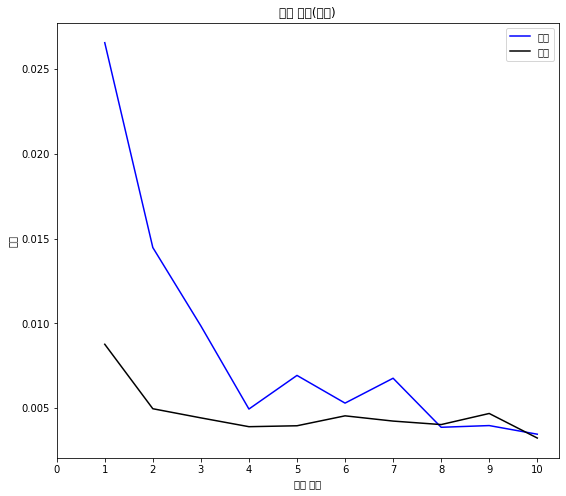

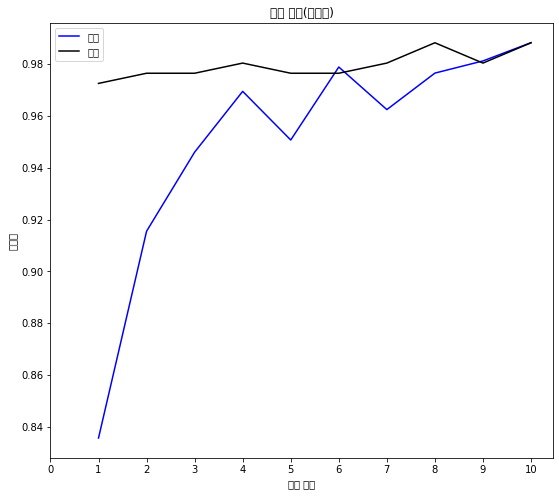

In [20]:
# 결과 그래프 확인
evaluate_history(history)

<Figure size 720x720 with 0 Axes>

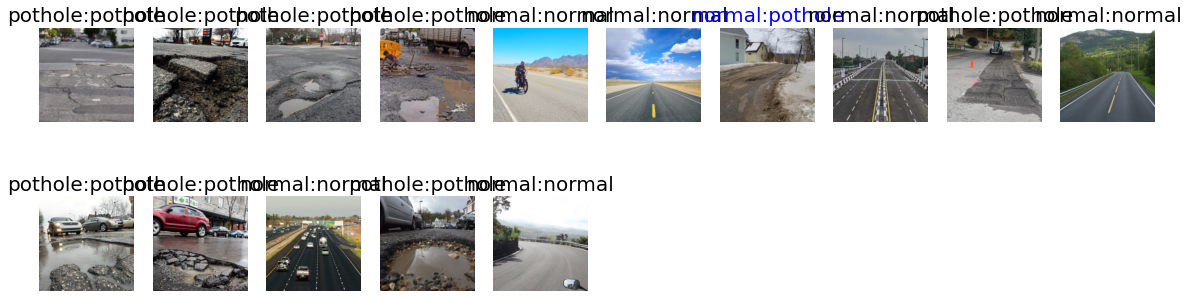

In [28]:
plt.figure(figsize=(10, 10))

show_images_labels(test_loader2, classes, net, device)

In [26]:
!tree

.
├── drive
│   └── MyDrive
│       ├── archive
│       │   ├── test
│       │   │   ├── normal
│       │   │   │   ├── 102.jpg
│       │   │   │   ├── 103.jpg
│       │   │   │   ├── 104.jpg
│       │   │   │   ├── 110.jpg
│       │   │   │   ├── 111.jpg
│       │   │   │   ├── 112.jpg
│       │   │   │   ├── 118.jpg
│       │   │   │   ├── 119.jpg
│       │   │   │   ├── 120.jpg
│       │   │   │   ├── 126.jpg
│       │   │   │   ├── 127.jpg
│       │   │   │   ├── 128.jpg
│       │   │   │   ├── 134.jpg
│       │   │   │   ├── 135.jpg
│       │   │   │   ├── 136.jpg
│       │   │   │   ├── 142.jpg
│       │   │   │   ├── 143.jpg
│       │   │   │   ├── 144.jpg
│       │   │   │   ├── 14.jpg
│       │   │   │   ├── 150.jpg
│       │   │   │   ├── 151.jpg
│       │   │   │   ├── 152.jpg
│       │   │   │   ├── 158.jpg
│       │   │   │   ├── 159.jpg
│       │   │   │   ├── 15.jpg
│       │   │   │   ├── 160.jpg
│       │   │   │   ├── 166.jpg
│       │   │   │   ├── 167.jpg
│       │ 